In [99]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re
from scipy.stats import f_oneway


# machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve

In [100]:
df = pd.read_csv("FXS x TSC_data_exported_trials_20250801.csv")
df.head()

,Time_since_file_start_(s),Stim_ID,Trial_type,Attempts_to_complete,Response,Reaction_(s),Type,Stim Source,Position,Dur (ms),...,complete_block_number,UUID,date,rat_name,rat_ID,Genotype,file_name,phase,task,detail
0,96.464997,5,5,12,Hit,0.197487,5,train,5,5300,...,1.0,20230117122826_96.4649967849255_1.49607365505489,20230117,Blue1,98,LE,32kHz_60dB_BBN_60dB_8s_4-6,Tone-BBN,CNO 3mg/kg,4-6
1,96.464997,5,5,12,Hit,0.197487,5,train,5,5300,...,1.0,20230117122826_96.4649967849255_1.49607365505489,20230117,Blue1,98,LE,32kHz_60dB_BBN_60dB_8s_4-6,Tone-BBN,CNO 3mg/kg,4-6
2,96.464997,5,5,12,Hit,0.197487,5,train,5,5300,...,1.0,20230117122826_96.4649967849255_1.49607365505489,20230117,Blue1,98,LE,32kHz_60dB_BBN_60dB_8s_4-6,Tone-BBN,CNO 3mg/kg,4-6
3,107.651005,4,5,2,Hit,0.224997,5,train,4,5300,...,1.0,20230117122826_96.4649967849255_1.49607365505489,20230117,Blue1,98,LE,32kHz_60dB_BBN_60dB_8s_4-6,Tone-BBN,CNO 3mg/kg,4-6
4,107.651005,4,5,2,Hit,0.224997,5,train,4,5300,...,1.0,20230117122826_96.4649967849255_1.49607365505489,20230117,Blue1,98,LE,32kHz_60dB_BBN_60dB_8s_4-6,Tone-BBN,CNO 3mg/kg,4-6


In [101]:
df.columns

Index(['Time_since_file_start_(s)', 'Stim_ID', 'Trial_type',
       'Attempts_to_complete', 'Response', 'Reaction_(s)', 'Type',
       'Stim Source', 'Position', 'Dur (ms)', 'Nose Out TL (s)',
       'Time Out (s)', 'Train Setting', 'Extra Check Point (s)', 'Delay (s)',
       'Trial_number', 'Block_number', 'complete_block_number', 'UUID', 'date',
       'rat_name', 'rat_ID', 'Genotype', 'file_name', 'phase', 'task',
       'detail'],
      dtype='object')

In [102]:
df.dtypes

Time_since_file_start_(s)    float64
Stim_ID                        int64
Trial_type                     int64
Attempts_to_complete           int64
Response                      object
Reaction_(s)                 float64
Type                           int64
Stim Source                   object
Position                       int64
Dur (ms)                       int64
Nose Out TL (s)              float64
Time Out (s)                   int64
Train Setting                 object
Extra Check Point (s)        float64
Delay (s)                    float64
Trial_number                   int64
Block_number                   int64
complete_block_number        float64
UUID                          object
date                           int64
rat_name                      object
rat_ID                         int64
Genotype                      object
file_name                     object
phase                         object
task                          object
detail                        object
d

In [103]:
print(df.head())
print(df.info())
print(df['Genotype'].value_counts())

   Time_since_file_start_(s)  Stim_ID  Trial_type  Attempts_to_complete  \
0                  96.464997        5           5                    12   
1                  96.464997        5           5                    12   
2                  96.464997        5           5                    12   
3                 107.651005        4           5                     2   
4                 107.651005        4           5                     2   

  Response  Reaction_(s)  Type Stim Source  Position  Dur (ms)  ...  \
0      Hit      0.197487     5       train         5      5300  ...   
1      Hit      0.197487     5       train         5      5300  ...   
2      Hit      0.197487     5       train         5      5300  ...   
3      Hit      0.224997     5       train         4      5300  ...   
4      Hit      0.224997     5       train         4      5300  ...   

   complete_block_number                                              UUID  \
0                    1.0  20230117122826_96.

In [104]:
# Binary variable: first attempt success = 1 attempt
df['first_attempt_success'] = df['Attempts_to_complete'].apply(lambda x: "Yes" if x == 1 else "No")

# Check counts
print(df['first_attempt_success'].value_counts())

first_attempt_success
Yes    1064015
No      737619
Name: count, dtype: int64


In [105]:
contingency_table = pd.crosstab(df['Genotype'], df['first_attempt_success'])
print(contingency_table)

# Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square test statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

# Effect size: Cramer's V
n = contingency_table.sum().sum()
cramers_v = (chi2 / (n * (min(contingency_table.shape) - 1))) ** 0.5
print("Cramer's V:", cramers_v)

first_attempt_success      No     Yes
Genotype                             
LE                     588913  682043
Tsc2_LE_WT             148706  381972
Chi-square test statistic: 51930.70592552339
p-value: 0.0
Degrees of freedom: 1
Expected frequencies:
 [[520350.57828838 750605.42171162]
 [217268.42171162 313409.57828838]]
Cramer's V: 0.16977698957411883


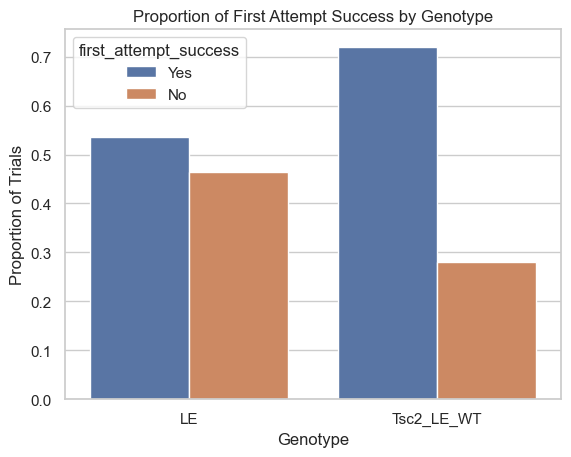

In [106]:
success_rates = df.groupby('Genotype')['first_attempt_success'].value_counts(normalize=True).rename('proportion').reset_index()

sns.barplot(data=success_rates, x='Genotype', y='proportion', hue='first_attempt_success')
plt.title("Proportion of First Attempt Success by Genotype")
plt.ylabel("Proportion of Trials")
plt.show()

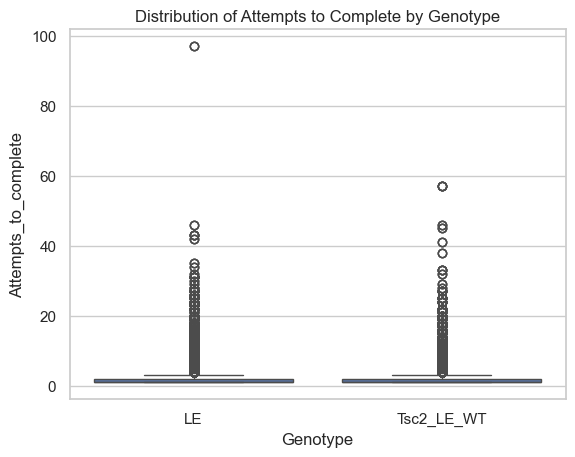

In [107]:
sns.boxplot(data=df, x='Genotype', y='Attempts_to_complete')
plt.title("Distribution of Attempts to Complete by Genotype")
plt.show()

In [108]:
# Step 2: Helper functions

def load_data(file_path, info_path):
    df = pd.read_csv(file_path)
    info_df = pd.read_csv(info_path)
    return df, info_df

def file_info(info_df):
    df = info_df[['file_name','UUID']]
    file_name_list = list(zip(df['file_name'], df['UUID']))
    file_info_list = [(file_name.split('_'), uuid) for file_name,uuid in file_name_list]
    file_info = [(tup[:-1],tup[-1]) for tup in file_info_list]
    file_uuid_list = [t[1] for t in file_info]
    file_info_df = pd.DataFrame(file_info, columns=['file_info','UUID'])
    merged_df = pd.merge(file_info_df, info_df, on="UUID", how="right")
    return merged_df[merged_df['UUID'].isin(file_uuid_list)]

def uuid_comparer(df, info_df):
    valid_UUIDs_set = set(info_df['UUID'])
    data_UUIDs_set = set(df['UUID'])
    return valid_UUIDs_set.intersection(data_UUIDs_set)

def round_delay(x):
    return np.round(x * 2) / 2

def data_cleaner(df, info_df, shared_UUIDs, wanted_columns):
    merged_df = pd.merge(df, info_df[wanted_columns], on="UUID", how="right")
    clean_df = merged_df[merged_df['UUID'].isin(shared_UUIDs)]
    clean_df = clean_df[clean_df['complete_block_number'] > 1]
    return clean_df

def delay_classifier(df):
    wanted_data = df[['Delay (s)','UUID']]
    delay_max_min_by_UUID = wanted_data.groupby(['UUID']).agg(['max','min'])
    rounded_delays = delay_max_min_by_UUID['Delay (s)'].map(round_delay)
    delay_intervals = rounded_delays.groupby(['max','min']).count()
    delay_interval_list = delay_intervals.index.tolist()
    
    df_with_classified_delays = pd.merge(df, rounded_delays, on='UUID', how='right')
    df_with_classified_delays = df_with_classified_delays.rename(columns={"max": "Max Delay (s)", "min": "Min Delay (s)"})
    
    return delay_interval_list, df_with_classified_delays

def rat_info(df, delay_interval): 
    df = df.loc[(df['Max Delay (s)'] == delay_interval[0])
                & (df['Min Delay (s)'] == delay_interval[1])
                & (df['Delay (s)'] > 2.5)]
    
    df['one_attempt'] = df['Attempts_to_complete'] == 1
    df['more_than_one_attempt'] = df['Attempts_to_complete'] > 1
    
    groups = df.groupby(['rat_ID', 'Genotype']).agg(
        trials_one_attempt=('one_attempt', 'sum'),
        trials_more_than_one_attempt=('more_than_one_attempt', 'sum'),
        total_trials=('Attempts_to_complete', 'count'))
    
    groups['prop_one_attempt'] = groups['trials_one_attempt'] / groups['total_trials']
    return groups.reset_index()

def genotype_bargraph(data):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.swarmplot(x='Genotype', y='prop_one_attempt', data=data, color='black', size=5)
    plt.title('Proportion of 1-Attempt Trials by Genotype')
    plt.ylabel('Proportion of Trials Completed in One Attempt')
    plt.xlabel('Genotype')
    plt.show()

In [109]:
# Step 3: Load data
file_path = "FXS x TSC_archive.csv"
file_info_path = "FXS x TSC_data_exported_20250801.csv"

wanted_columns_for_merge = ['date','UUID','weight','rat_ID','DOB','file_name','Genotype']
wanted_delay_interval = (4.0,1.0)  # adjust as needed

df, info_df = load_data(file_path, file_info_path)
info_df = file_info(info_df)
shared_UUIDs = uuid_comparer(df, info_df)
clean_df = data_cleaner(df, info_df, shared_UUIDs, wanted_columns_for_merge)
delay_interval_list, delay_df = delay_classifier(clean_df)

rat_data = rat_info(delay_df, wanted_delay_interval)
print(rat_data.head())
print(delay_df.head())
print(clean_df.head())

   rat_ID          Genotype  trials_one_attempt  trials_more_than_one_attempt  \
0     744   Fmr1_KO-Tsc2_WT               21192                          3758   
1     745   Fmr1_KO-Tsc2_WT                2988                          2998   
2     746  Fmr1_WT-Tsc2_Het               22904                         10869   
3     747   Fmr1_WT-Tsc2_WT               24272                         10944   
4     748  Fmr1_KO-Tsc2_Het               22684                         11233   

   total_trials  prop_one_attempt  
0         24950          0.849379  
1          5986          0.499165  
2         33773          0.678175  
3         35216          0.689232  
4         33917          0.668809  
   Time_since_file_start_(s)  Stim_ID  Trial_type  Attempts_to_complete  \
0                1039.429999      1.0         1.0                   3.0   
1                1094.029994      1.0         1.0                   2.0   
2                1374.839998      1.0         1.0                   1.0 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20080\1552023079.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['one_attempt'] = df['Attempts_to_complete'] == 1
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20080\1552023079.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['more_than_one_attempt'] = df['Attempts_to_complete'] > 1


In [110]:
delay_df.columns

Index(['Time_since_file_start_(s)', 'Stim_ID', 'Trial_type',
       'Attempts_to_complete', 'Response', 'Reaction_(s)', 'Type',
       'Stim Source', 'Freq (kHz)', 'Inten (dB)', 'Dur (ms)',
       'Nose Out TL (s)', 'Time Out (s)', 'Delay (s)', 'Trial_number',
       'Block_number', 'complete_block_number', 'UUID', 'date', 'weight',
       'rat_ID', 'DOB', 'file_name', 'Genotype', 'Max Delay (s)',
       'Min Delay (s)'],
      dtype='object')

In [111]:
delay_df["Genotype"].unique()

array(['Fmr1_KO-Tsc2_WT', 'Fmr1_WT-Tsc2_Het', 'Fmr1_WT-Tsc2_WT',
       'Fmr1_KO-Tsc2_Het'], dtype=object)

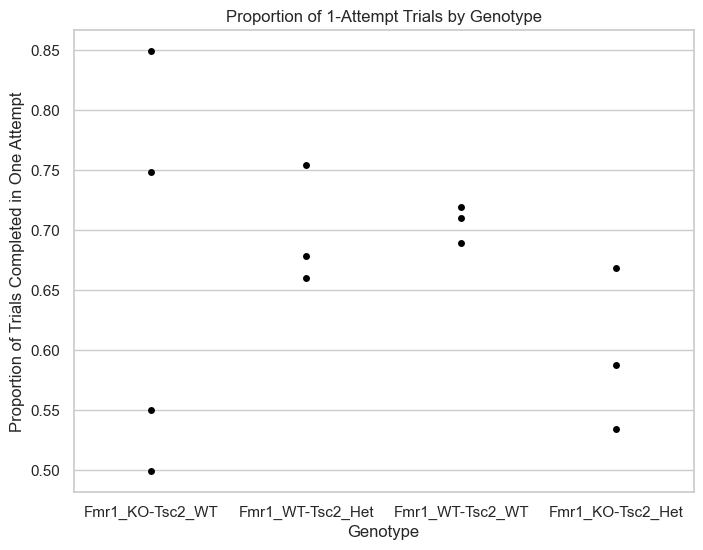

In [112]:
# Step 4: Visualization
genotype_bargraph(rat_data)

Chi-Square Test:
Test whether genotype is associated with success on the first attempt (yes/no).

In [113]:
# Step 5: Chi-Square Test
contingency = pd.pivot_table(rat_data, 
                             values='trials_one_attempt', 
                             index='Genotype', 
                             aggfunc='sum')

# Add more_than_one_attempt counts
contingency['trials_more_than_one_attempt'] = rat_data.groupby('Genotype')['trials_more_than_one_attempt'].sum()
contingency = contingency.astype(int)

chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test results")
print("-----------------------")
print("Chi2 statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:\n", expected)

Chi-square test results
-----------------------
Chi2 statistic: 3222.588813292243
p-value: 0.0
Degrees of freedom: 3
Expected frequencies:
 [[54248.39495999 25180.60504001]
 [44418.26807108 20617.73192892]
 [54953.91299489 25508.08700511]
 [49267.42397404 22868.57602596]]


If p < 0.05 → Genotype does affect probability of first-attempt success.

Cramér’s V tells us effect size:

0.1 = small, 0.3 = medium, 0.5 = large.

One-Way ANOVA:
When we treat proportion as continuous outcome;
compare mean number of attempts across genotypes.

In [114]:
# Step 6: One-Way ANOVA
groups = [rat_data.loc[rat_data['Genotype']==g, 'prop_one_attempt'] for g in rat_data['Genotype'].unique()]
anova_stat, anova_p = f_oneway(*groups)

print("\nANOVA results")
print("-------------")
print("F-statistic:", anova_stat)
print("p-value:", anova_p)


ANOVA results
-------------
F-statistic: 0.6943406255671655
p-value: 0.5783538338644758


If ANOVA is significant (p < 0.05), do post-hoc tests (Tukey HSD) to see which groups differ.
If ANOVA p < 0.05 → at least one genotype has a different mean attempts-to-complete.

Tukey HSD tells us which pairs are significantly different.

In [115]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_sdt_measures(df,
                         subject_col='rat_ID',
                         session_col='UUID',   # optional grouping col
                         go_mask_col='Trial_type', # define what encodes "go" (you may adapt)
                         response_col='Response'):
    """
    Return dataframe with columns: subject, session (if present),
    go_trials, hits, no_go_trials, false_alarms, hit_rate, fa_rate, dprime, criterion
    """
    # define mapping for your data: we assume Trial_type==1 is "go", 0 is "no-go"
    # and Response strings indicate 'hit', 'miss', 'false alarm', 'correct reject'
    # Adjust masks below to match your dataset values.
    
    df['is_go'] = df['Trial_type'] == 1  # adjust if needed
    df['is_hit'] = df['is_go'] & df[response_col].str.lower().str.contains('hit', na=False)
    df['is_fa']  = (~df['is_go']) & df[response_col].str.lower().str.contains('false', na=False)
    
    group_cols = [subject_col]
    if session_col in df.columns:
        group_cols.append(session_col)
    
    agg = df.groupby(group_cols).agg(
        go_trials = ('is_go', 'sum'),
        hits = ('is_hit', 'sum'),
        no_go_trials = (lambda x: (~x).sum(), 'is_go') if False else ('is_go','count') # placeholder
    )
    # easier explicit:
    g = df.groupby(group_cols)
    stats = pd.DataFrame({
        'go_trials': g['is_go'].sum(),
        'hits': g['is_hit'].sum(),
        'no_go_trials': (~g['is_go']).sum(),
        'false_alarms': g['is_fa'].sum()
    }).reset_index()
    
    # calculate rates with adjustments
    stats['hit_rate'] = (stats['hits'] + 0.5) / (stats['go_trials'] + 1)
    stats['fa_rate']  = (stats['false_alarms'] + 0.5) / (stats['no_go_trials'] + 1)
    
    # z transform
    stats['zH'] = stats['hit_rate'].apply(lambda x: norm.ppf(x))
    stats['zF'] = stats['fa_rate'].apply(lambda x: norm.ppf(x))
    stats['dprime'] = stats['zH'] - stats['zF']
    stats['criterion'] = -0.5 * (stats['zH'] + stats['zF'])
    
    return stats


In [116]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from statannotations.Annotator import Annotator

# Example: df has ['Genotype', 'Sex', 'FirstAttempt']
# FirstAttempt = 1 if completed on first attempt, else 0

#prop_df = df.groupby(['rat_ID', 'Genotype', 'Sex'])['FirstAttempt'].mean().reset_index()

#plt.figure(figsize=(7,5))
#sns.barplot(data=prop_df, x='Genotype', y='FirstAttempt', hue='Sex', errorbar='se')

#pairs = [(('WT','Male'), ('Tsc2','Male')), (('WT','Female'), ('Tsc2','Female'))]
#annotator = Annotator(plt.gca(), pairs, data=prop_df, x='Genotype', y='FirstAttempt', hue='Sex')
#annotator.configure(test='t-test_ind', text_format='star', loc='inside')
#annotator.apply_and_annotate()

#plt.ylabel("Proportion of First-Attempt Completions")
#plt.title("Genotype & Sex Effects on First Attempt Success")
#plt.ylim(0, 1)
#plt.show()

In [117]:
#from statannotations.Annotator import Annotator

In [118]:
print(delay_df['Genotype'].unique())
delay_df['first_attempt_success'] = (delay_df['Attempts_to_complete'] == 1).astype(int)
delay_df['long_delay'] = (delay_df['Delay (s)'] > 2.5).astype(int)

['Fmr1_KO-Tsc2_WT' 'Fmr1_WT-Tsc2_Het' 'Fmr1_WT-Tsc2_WT' 'Fmr1_KO-Tsc2_Het']


In [119]:
delay_df[['Fmr1', 'Tsc2']] = delay_df['Genotype'].str.split('-', expand=True)
delay_df['Fmr1'] = delay_df['Fmr1'].str.replace('Fmr1_', '', regex=False)
delay_df['Tsc2'] = delay_df['Tsc2'].str.replace('Tsc2_', '', regex=False)

In [120]:
print(delay_df[['Genotype', 'Fmr1', 'Tsc2']].drop_duplicates())

             Genotype Fmr1 Tsc2
0     Fmr1_KO-Tsc2_WT   KO   WT
10   Fmr1_WT-Tsc2_Het   WT  Het
20    Fmr1_WT-Tsc2_WT   WT   WT
100  Fmr1_KO-Tsc2_Het   KO  Het


In [121]:
summary = (
    delay_df.groupby(['Fmr1', 'Tsc2', 'long_delay'])['first_attempt_success']
      .agg(['mean', 'count'])
      .reset_index()
)
summary['delay_group'] = summary['long_delay'].map({0: '≤2.5 s', 1: '>2.5 s'})
print(summary)

  Fmr1 Tsc2  long_delay      mean   count delay_group
0   KO  Het           0  0.719673   98371      ≤2.5 s
1   KO  Het           1  0.606480   80029      >2.5 s
2   KO   WT           0  0.773656  112594      ≤2.5 s
3   KO   WT           1  0.738934   65313      >2.5 s
4   WT  Het           0  0.803023  100880      ≤2.5 s
5   WT  Het           1  0.695235   80790      >2.5 s
6   WT   WT           0  0.812129  110246      ≤2.5 s
7   WT   WT           1  0.701444   72854      >2.5 s


In [122]:
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

model = smf.glm(
    'first_attempt_success ~ C(Fmr1) * C(Tsc2) * long_delay',
    data=delay_df,
    family=sm.families.Binomial()
).fit()

print(model.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     first_attempt_success   No. Observations:               721077
Model:                               GLM   Df Residuals:                   721069
Model Family:                   Binomial   Df Model:                            7
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:            -4.0713e+05
Date:                   Tue, 14 Oct 2025   Deviance:                   8.1425e+05
Time:                           17:55:56   Pearson chi2:                 7.21e+05
No. Iterations:                        5   Pseudo R-squ. (CS):            0.01982
Covariance Type:               nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

In [123]:
np.exp(model.params)

Intercept                                 2.567269
C(Fmr1)[T.WT]                             1.587970
C(Tsc2)[T.WT]                             1.331395
C(Fmr1)[T.WT]:C(Tsc2)[T.WT]               0.796426
long_delay                                0.600314
C(Fmr1)[T.WT]:long_delay                  0.932123
C(Tsc2)[T.WT]:long_delay                  1.379426
C(Fmr1)[T.WT]:C(Tsc2)[T.WT]:long_delay    0.704127
dtype: float64

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20080\645909365.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(


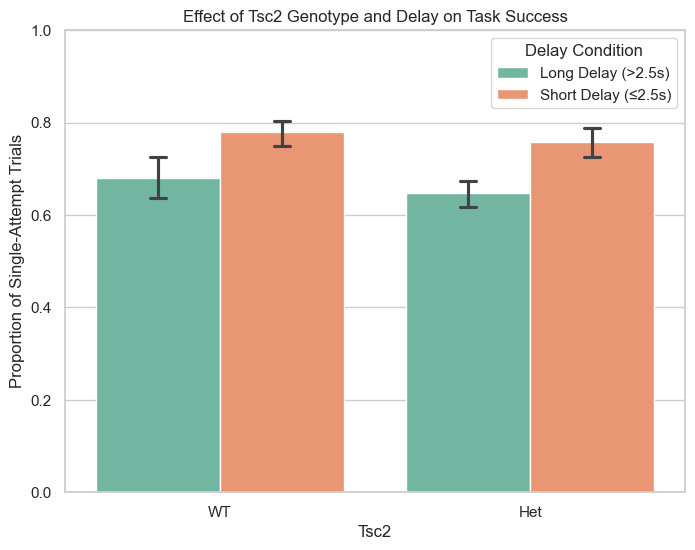

In [124]:
# Create 'long_delay' binary column
delay_df['long_delay'] = (delay_df['Delay (s)'] > 2.5).astype(int)
delay_df['long_delay_label'] = delay_df['long_delay'].map({0: 'Short Delay (≤2.5s)', 1: 'Long Delay (>2.5s)'})

# Simplify genotype labeling (split Fmr1/Tsc2)
delay_df[['Fmr1', 'Tsc2']] = delay_df['Genotype'].str.split('-', expand=True)
delay_df['Tsc2'] = delay_df['Tsc2'].str.replace('Tsc2_', '')  # keep only WT or Het

# Calculate proportion of success per rat × condition
delay_df['first_attempt_success'] = (delay_df['Attempts_to_complete'] == 1).astype(int)
summary = (
    delay_df.groupby(['rat_ID', 'Tsc2', 'long_delay_label'])['first_attempt_success']
      .mean()
      .reset_index()
)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=summary,
    x='Tsc2', y='first_attempt_success', hue='long_delay_label',
    ci=68, capsize=.1, palette='Set2'
)
plt.ylabel('Proportion of Single-Attempt Trials')
plt.title('Effect of Tsc2 Genotype and Delay on Task Success')
plt.ylim(0, 1)
plt.legend(title='Delay Condition')
plt.show()

In [125]:

data = delay_df.copy()

# Binary variable: success on first attempt
data['first_attempt_success'] = (data['Attempts_to_complete'] == 1).astype(int)

# Binary variable: delay > 2.5 s
data['long_delay'] = (data['Delay (s)'] > 2.5).astype(int)
data['Delay'] = data['long_delay'].map({0: 'Short (≤2.5s)', 1: 'Long (>2.5s)'})

# Split Genotype into Fmr1 and Tsc2 components
data[['Fmr1', 'Tsc2']] = data['Genotype'].str.split('-', expand=True)
data['Fmr1'] = data['Fmr1'].str.replace('Fmr1_', '')
data['Tsc2'] = data['Tsc2'].str.replace('Tsc2_', '')

# Aggregate to rat-level mean success rate
rat_summary = (
    data.groupby(['rat_ID', 'Fmr1', 'Tsc2', 'Delay'])['first_attempt_success']
    .mean()
    .reset_index()
)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20080\1813503218.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


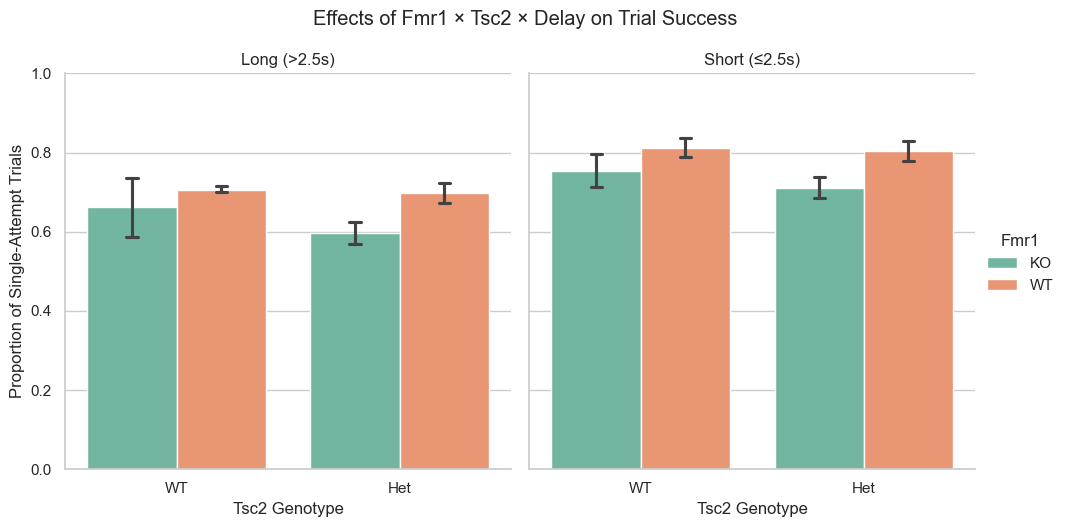

In [126]:
g = sns.catplot(
    data=rat_summary,
    x='Tsc2', y='first_attempt_success',
    hue='Fmr1', col='Delay',
    kind='bar', ci=68, capsize=.1, palette='Set2',
    height=5, aspect=1
)
g.set_axis_labels('Tsc2 Genotype', 'Proportion of Single-Attempt Trials')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Effects of Fmr1 × Tsc2 × Delay on Trial Success', y=1.05)
plt.ylim(0, 1)
plt.show()

In [127]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.glm(
    'first_attempt_success ~ C(Fmr1) * C(Tsc2) * C(Delay)',
    data=rat_summary,
    family=sm.families.Binomial()
).fit()

print(model.summary())

                   Generalized Linear Model Regression Results                   
Dep. Variable:     first_attempt_success   No. Observations:                   26
Model:                               GLM   Df Residuals:                       18
Model Family:                   Binomial   Df Model:                            7
Link Function:                     Logit   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -10.330
Date:                   Tue, 14 Oct 2025   Deviance:                      0.72455
Time:                           17:55:59   Pearson chi2:                    0.697
No. Iterations:                        4   Pseudo R-squ. (CS):            0.02134
Covariance Type:               nonrobust                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

In [135]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# average per animal per condition
df_means = rat_summary.groupby(["rat_ID", "Fmr1", "Tsc2", "Delay"])["first_attempt_success"].mean().reset_index()

# run 3-way ANOVA
model = ols("first_attempt_success ~ C(Fmr1) * C(Tsc2) * C(Delay)", data=df_means).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                            sum_sq    df         F    PR(>F)
C(Fmr1)                   0.033934   1.0  4.195738  0.055398
C(Tsc2)                   0.006913   1.0  0.854795  0.367429
C(Delay)                  0.070410   1.0  8.705685  0.008557
C(Fmr1):C(Tsc2)           0.003278   1.0  0.405354  0.532351
C(Fmr1):C(Delay)          0.000011   1.0  0.001315  0.971473
C(Tsc2):C(Delay)          0.000223   1.0  0.027582  0.869946
C(Fmr1):C(Tsc2):C(Delay)  0.000201   1.0  0.024833  0.876538
Residual                  0.145580  18.0       NaN       NaN


Delay has a strong effect:
Rats are significantly less likely to complete the trial on the first attempt when the delay is long (>2.5s).
→ This aligns directly with your hypothesis that “long delays reduce single-attempt success.”

Fmr1 genotype shows a trend:
p = 0.055 is borderline; you might call it a trend toward significance (especially if you expect this biologically).

No evidence of Tsc2 or interactions:
Tsc2 doesn’t seem to independently affect performance in this sample, and the combined Fmr1–Tsc2–Delay effects weren’t significant — possibly due to small N (df Residual = 18).

Text(0.5, 0.98, 'First-Attempt Success by Fmr1 × Tsc2 × Delay')

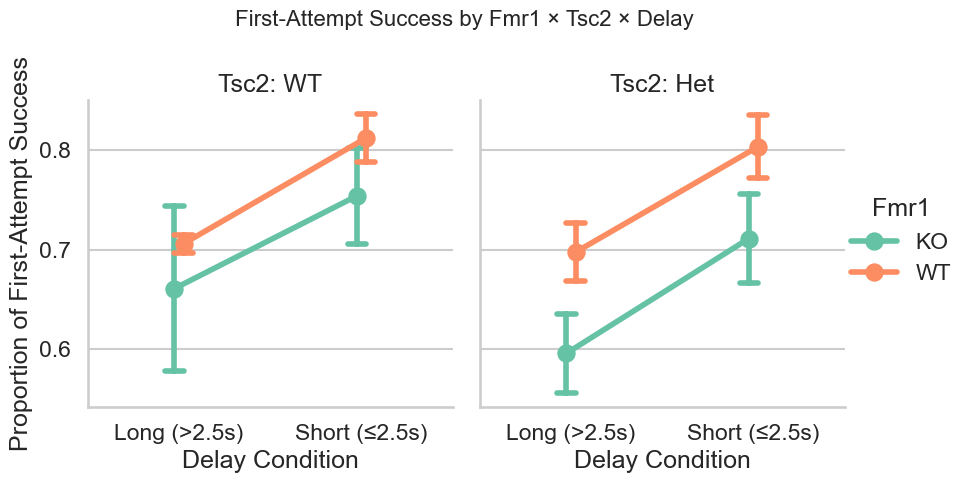

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="talk")

g = sns.catplot(
    data=df_means,
    x="Delay",
    y="first_attempt_success",
    hue="Fmr1",
    col="Tsc2",
    kind="point",
    dodge=True,
    capsize=0.1,
    errorbar="se",
    palette="Set2",
    height=5,
    aspect=0.9
)

g.set_axis_labels("Delay Condition", "Proportion of First-Attempt Success")
g.set_titles("Tsc2: {col_name}")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("First-Attempt Success by Fmr1 × Tsc2 × Delay", fontsize=16)

Hypothesis II:

In [147]:
import statsmodels.formula.api as smf
#model_lin = smf.glm('first_attempt_success ~ C(Fmr1)*C(Tsc2) + Delay',
                    data=delay_df, family=sm.families.Binomial()).fit()

#model_quad = smf.glm('first_attempt_success ~ C(Fmr1)*C(Tsc2) + Delay + I(Delay**2)', #data=delay_df, family=sm.families.Binomial()).fit()

#print("Linear Delay AIC:", model_lin.aic)
#print("Quadratic Delay AIC:", model_quad.aic)
#print(model_quad.summary())

IndentationError: unexpected indent (2162114379.py, line 3)

In [148]:
print(df["Trial_type"].unique())

[5 0]


In [149]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def compute_dprime(hit_rate, fa_rate):
    """Compute signal detection sensitivity (d′)."""
    hit_rate = np.clip(hit_rate, 1e-5, 1 - 1e-5)
    fa_rate = np.clip(fa_rate, 1e-5, 1 - 1e-5)
    return norm.ppf(hit_rate) - norm.ppf(fa_rate)

# Load data
df = pd.read_csv("FXS x TSC_data_exported_trials_20250801.csv")

# Define short vs long delay
df["Delay_type"] = np.where(df["Delay (s)"] > 2.5, "Long", "Short")

# Define correctness (adjust this if your dataset uses 1/0 instead of strings)
df["correct"] = df["Response"].apply(lambda x: 1 if x == "Correct" or x == 1 else 0)

# Define Go vs No-Go trials based on the codes you shared
df["is_go"] = df["Trial_type"].apply(lambda x: 1 if x == 5 else 0)

# Compute hit rate (Go trials correct) and false alarm rate (No-Go trials incorrect)
summary = (
    df.groupby(["rat_ID", "Genotype", "Delay_type"])
    .apply(lambda x: pd.Series({
        "hit_rate": x.loc[x["is_go"] == 1, "correct"].mean(),
        "fa_rate": 1 - x.loc[x["is_go"] == 0, "correct"].mean()
    }))
    .reset_index()
)

# Compute d'
summary["dprime"] = summary.apply(lambda r: compute_dprime(r["hit_rate"], r["fa_rate"]), axis=1)

print(summary.head())

   rat_ID    Genotype Delay_type  hit_rate  fa_rate    dprime
0      98          LE      Short       0.0      1.0 -8.529782
1      99          LE      Short       0.0      1.0 -8.529782
2     101          LE      Short       0.0      1.0 -8.529782
3     140  Tsc2_LE_WT      Short       0.0      1.0 -8.529782
4     153  Tsc2_LE_WT      Short       0.0      1.0 -8.529782


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20080\3016107582.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


???